In [85]:
import numpy as np
import csv
import pandas
from math import isnan
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import neighbors
#from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn import datasets
from sklearn.svm import LinearSVC,SVC
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.random_projection import SparseRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, Activation, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.cross_validation import cross_val_score

In [7]:
#reading dataset
df = pandas.read_csv('train_dig.csv')

In [8]:
#checking if we're missing data
df.isnull().sum().sum()
#we don't

0

In [9]:
#deviding to data and prediction
df_x=df.drop(['label'],axis=1)
df_y=df['label']

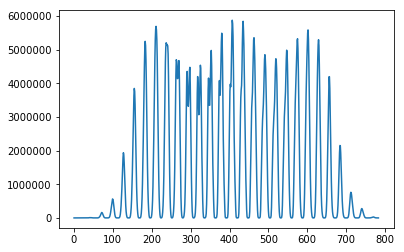

In [10]:
#plotting data - notice that we have ~ 100 pixels we can remove without damaging data
plt.plot(df_x.sum().as_matrix())

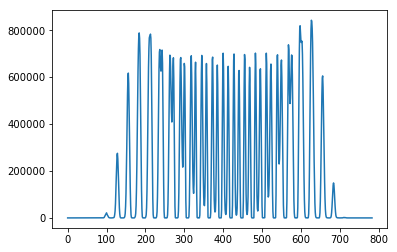

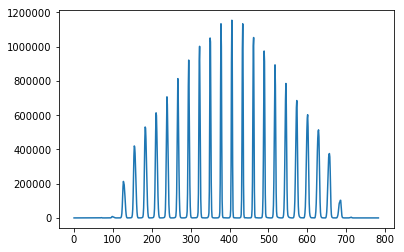

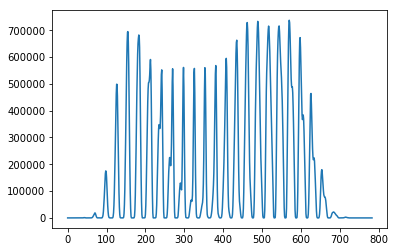

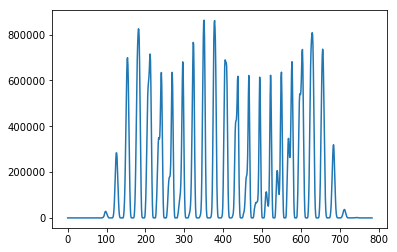

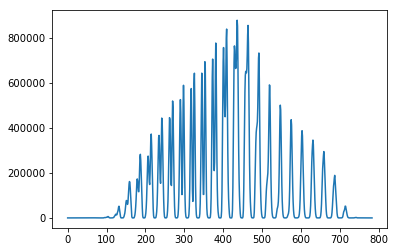

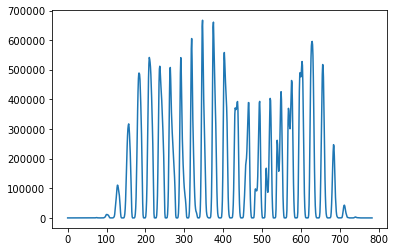

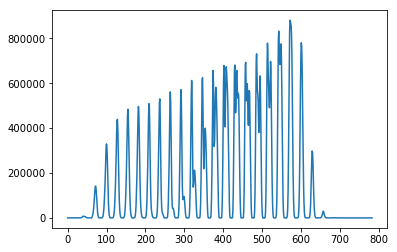

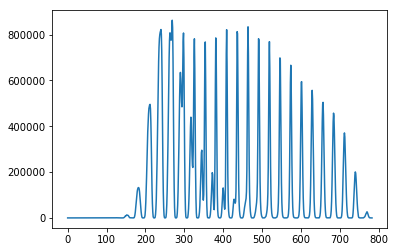

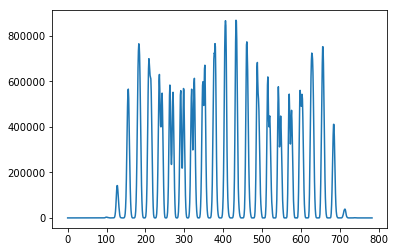

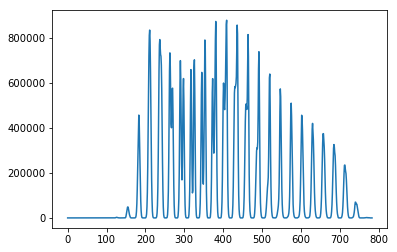

In [11]:
#Thinking of trimming the edges, however different letters are centered differently on average, will bias the score
for i in range(10):
    plt.figure();
    plt.plot(df[df['label']==i].drop(['label'],axis=1).sum().as_matrix())

In [12]:
np.isinf(df).sum().sum()

0

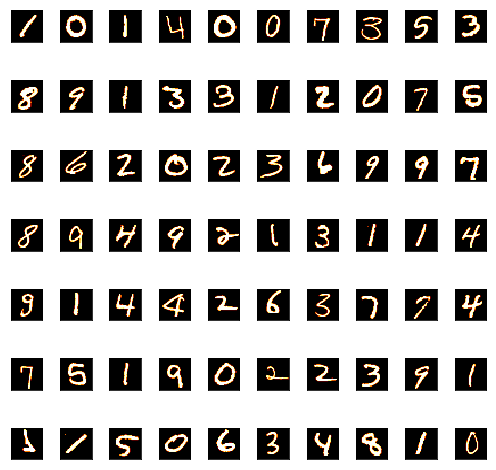

In [13]:
# plot some of the numbers
plt.figure(figsize=(7,7))
for digit_num in range(0,70):
    plt.subplot(7,10,digit_num+1)
    grid_data = df_x.iloc[digit_num].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [9]:
#Trying a PCA approach to dimensionality reduction without normalizing, emphisizing, etc.
n_comp = 3;
pca = PCA(152)
reduced_X=pca.fit_transform((df_x))

In [10]:
len(df.ix[3])

785

In [11]:
A=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#np.where((A>95) == True)

In [12]:
#Trying to use a simple SVC to solve the problem after pca reduction to 152 dim
#OVC=OneVsRestClassifier(LinearSVC(random_state=0)).fit(df_x, df_y)
#scores=cross_val_score(OVC,df_x,df_y,cv=2)
#OVC.score(df_x,df_y)
#scored approximately 85% 

In [21]:
#KNN
#Trying a PCA approach to dimensionality reductionc.
n_comp = 20;
pca = PCA(n_comp)
reduced_X_kNN=pca.fit_transform(scale(df_x,axis=1))

In [14]:
def print_pca_eigen(pca):
    n_row = 5
    n_col = 4
    eigenvalues = pca.components_
    # Plot the first 8 eignenvalues
    plt.figure(figsize=(8,7))
    for i in list(range(n_row * n_col)):
    #     for offset in [10, 30,0]:
    #     plt.subplot(n_row, n_col, i + 1)
        offset =0
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(eigenvalues[i].reshape(28,28), cmap='jet')
        title_text = 'Eigenvalue ' + str(i + 1)
        plt.title(title_text, size=6.5)
        plt.xticks(())
        plt.yticks(())
    plt.show()


In [15]:
#the pca eigen without any standartizing:
#print_pca_eigen(pca)

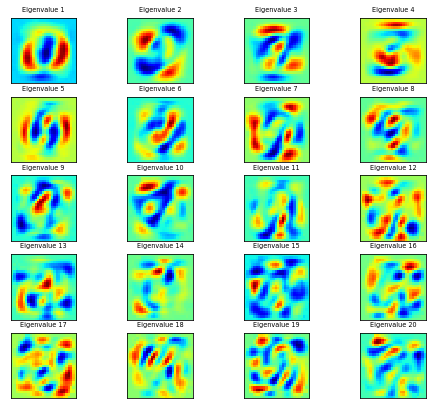

In [221]:
#the pca eigen with standartizing using scale features
print_pca_eigen(pca)

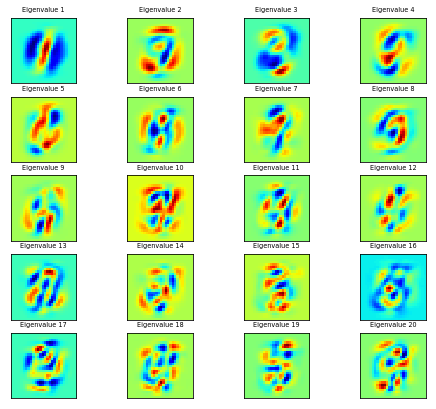

In [211]:
#the pca eigen with standartizing:
print_pca_eigen(pca)

In [22]:
#Trying the K-NN approach. first we would like to sample 500 f.e. digit, train on it, and try to predict the rest
sample_size = 500
digits_list = [df[df['label']==i] for i in range(10)]
#x_dig_train = []
#y_dig_train = []
df1 = pandas.DataFrame()
for dig in digits_list:
    dig_train = dig.sample(sample_size)
    #x_dig_train.append(dig_train.drop(['label'],axis=1).index.values.astype(int))
    df1=df1.append(dig_train)
#y_dig_train.append(dig_train['label'].index.values.astype(int))
#n_comp = 20;
#pca = PCA(n_comp)
#reduced_X_kNN=pca.fit_transform((df_x))

In [23]:
#should fit the pca to all data before transforming thi
df1_x = pca.transform(scale(df1.drop(['label'],axis=1),axis=1))
df1_y = df1['label'].as_matrix().astype(int)
df2=df.drop(df1.index)
df2_x = pca.transform(scale(df2.drop(['label'],axis=1),axis=1))
df2_y = df2['label'].as_matrix().astype(int)

In [24]:
#Trying different neighbors numbers
test_score = [];
val_score = [];
nei_num = range(1,10)
for i in nei_num:
    n_neighbors=i
    weights = 'distance'
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(df1_x, df1_y)
    test_score.append(clf.score(df1_x,df1_y))
    val_score.append(clf.score(df2_x,df2_y))

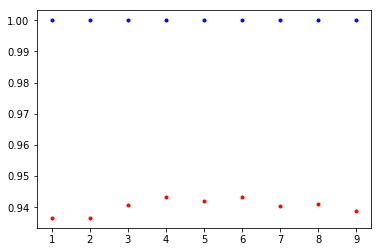

In [25]:
plt.plot(nei_num,test_score,'.b')
plt.plot(nei_num,val_score,'.r')
#getting 94% with pca to 20 500 samples from each letter than 3 n.n with uniform weights
#getting 95% with pca to 20 1000 samples from each letter than 3 n.n with distance weights
#getting ~96% with pca to 21 1000 samples from each letter than 4 n.n with distance weights
#getting ~96.1% with pca to 30 1000 samples from each letter than 4 n.n with distance weights
#getting 95.2% pca with normalized samples (20,500,3) about the same for scaling them.
#getting 91% with LDA(9) (scaling the features, same when scaling the samples)
#Combining LDA with PCA failed (<90%)
#To conclude KNN brings us to up to 96% from examples in the site we could go as up to ~98.5% with SVC and the rest is achieved
#using CNN 

In [260]:
#Trying to combine PCA and LDA approach to dimensionality reduction
n_comp = 200;
pca = PCA(n_comp)
reduced_X_kNN=pca.fit_transform(scale(df_x,axis=1))
lda = LDA(n_components=9)
X_LDA_2D = lda.fit_transform(reduced_X_kNN, df_y)
X_LDA_2D
#doesn't work so well

array([[  1.34597306e+00,   4.49824683e+00,  -2.57425415e-01, ...,
         -1.58184096e-01,   5.17595418e-01,   7.95179747e-02],
       [ -3.92710844e+00,  -1.97654220e+00,  -2.43473270e+00, ...,
          6.78023198e-02,  -1.14545090e+00,   7.27038837e-01],
       [  1.19252858e+00,   6.05796822e+00,   1.84159499e-01, ...,
          5.58025490e-01,   3.22259305e-01,  -3.04130474e-03],
       ..., 
       [  2.66900840e+00,  -2.55337089e+00,  -3.12064930e+00, ...,
         -1.69067782e+00,   4.65462527e-01,  -3.48507380e-02],
       [ -3.14953603e+00,  -1.04217566e+00,   4.13525991e+00, ...,
          9.52881962e-01,   1.14744527e+00,  -1.62940042e-01],
       [  2.16913648e+00,  -1.69915324e+00,   6.45192620e-01, ...,
         -5.99727797e-01,  -1.89215695e+00,  -7.74405130e-01]])

In [16]:
#Trying non-linear support vector machine approach. taken from kaggles Kernels. should predict ~ 98.5%
sc = MinMaxScaler()
X = sc.fit_transform(df_x.values)
X_train, X_holdout, y_train, y_holdout = train_test_split(
                                            X,
                                            df_y.values,
                                            test_size=0.15,
                                            random_state=42,
                                            # to preserve initial class balance
                                            stratify=df[df.columns[0]].values, 
                                                         )

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [19]:
clf = SVC(C=12,
          kernel='rbf',
          class_weight='balanced',
          random_state=42
         )
pca = PCA(n_components=40, random_state=42)
X_transformed = pca.fit_transform(X_train)
clf.fit(X_transformed, y_train)
acc = clf.score((pca.transform(X_holdout)), y_holdout)
print(acc)
# A really good score of 98.2% with n_comp=40 normalizing with minMaxScalar had a big impact

0.981428571429


D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [66]:
#CNN aproach, taken from Kaggle kernels (Keras CNN with >99%)
#works only in python < 3.6 with keras + tensorflow installed. 
#Normalizing data to [0,1]
# I got up to 98.5% but i'm sure it could be raised with a little tweaking of lr and epochs.
sc = MinMaxScaler()
X = sc.fit_transform(df_x.values)
#binarizing data
lb = LabelBinarizer()
lb.fit(df_y.values)
x_train, x_val, y_train, y_val = train_test_split(
                                            X,
                                            df_y.values,
                                            test_size=0.125,
                                            random_state=42,
                                            # to preserve initial class balance
                                            stratify=df[df.columns[0]].values, 
                                                         )
n_train = len(x_train)
y_train = lb.transform(y_train)
y_val = lb.transform(y_val)
n_classes=len(lb.classes_)
x_train = x_train.reshape(len(x_train), 28, 28,1)
x_val = x_val.reshape(len(x_val), 28, 28,1)

D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [74]:
x_train[0,:,:,0].shape

(28, 28)

In [87]:
#creating the cnn
model = Sequential()
# [conv,activation]x2 + pooling
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (28, 28, 1), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(filters = 32, kernel_size = (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# [conv,activation]x2 + pooling
model.add(Conv2D(filters = 64, kernel_size = (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# flattening the data and adding activation
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [88]:
#changing the data randomly, maybe remove zoom range?
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 20)

In [94]:
#compiling our model
#uses Adam which is an efficient varient of SGD 
#accuracy metric is simply how many counts we got right vs. how many we got wrong
#our loss function categorical_crossentropy -> basically how far is our one-hot-encoded data from the predictions.
#Notice that our learning rate is currently 1e-3 which could be lowered to increase results
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=5e-4), metrics = ["accuracy"])

In [95]:
#Model checkpoint allow us to restore the data after each epoch using model.load_weights(''mnist.h5'')
#Early stopping will stop the model from running if our val_loss has stop improving
#verbose print log after each batch
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=2, mode='auto'),
            ModelCheckpoint('mnist.h5', monitor='val_loss', save_best_only=True, verbose=0)]

In [101]:
#Model training
#run the data on 64 samples at a time.
batch_size = 64;
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
                           steps_per_epoch = int(n_train/batch_size),
                           epochs = 10, 
                           verbose = 2,  
                           validation_data = (x_val, y_val),
                           callbacks = callbacks)

Epoch 1/10
173s - loss: 0.0509 - acc: 0.9849 - val_loss: 0.0177 - val_acc: 0.9943
Epoch 2/10
192s - loss: 0.0535 - acc: 0.9848 - val_loss: 0.0227 - val_acc: 0.9939
Epoch 3/10
202s - loss: 0.0530 - acc: 0.9843 - val_loss: 0.0209 - val_acc: 0.9941
Epoch 4/10
192s - loss: 0.0486 - acc: 0.9855 - val_loss: 0.0186 - val_acc: 0.9958
Epoch 00003: early stopping


In [93]:
#Model training
#run the data on 64 samples at a time.
batch_size = 64;
hist2 = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
                           steps_per_epoch = int(n_train/batch_size),
                           epochs = 10, 
                           verbose = 2,  
                           validation_data = (x_val, y_val),
                           callbacks = callbacks)

Epoch 1/10
168s - loss: 0.1280 - acc: 0.9626 - val_loss: 0.0339 - val_acc: 0.9893
Epoch 2/10
172s - loss: 0.1221 - acc: 0.9624 - val_loss: 0.0357 - val_acc: 0.9895
Epoch 3/10
172s - loss: 0.1226 - acc: 0.9630 - val_loss: 0.0340 - val_acc: 0.9888
Epoch 4/10
169s - loss: 0.1230 - acc: 0.9624 - val_loss: 0.0340 - val_acc: 0.9897
Epoch 00003: early stopping


In [86]:
#Training the data for another 5 epochs
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
                           steps_per_epoch = int(n_train/batch_size),
                           epochs = 5, 
                           verbose = 1,  
                           validation_data = (x_val, y_val),
                           callbacks = callbacks)

Epoch 1/5
574/574 [==============================] - 189s - loss: 0.1110 - acc: 0.9674 - val_loss: 0.0269 - val_acc: 0.9924
Epoch 2/5
574/574 [==============================] - 193s - loss: 0.1015 - acc: 0.9712 - val_loss: 0.0302 - val_acc: 0.9912
Epoch 3/5
574/574 [==============================] - 191s - loss: 0.0964 - acc: 0.9721 - val_loss: 0.0249 - val_acc: 0.9918
Epoch 4/5
574/574 [==============================] - 191s - loss: 0.0907 - acc: 0.9737 - val_loss: 0.0282 - val_acc: 0.9907
Epoch 5/5
574/574 [==============================] - 188s - loss: 0.0889 - acc: 0.9749 - val_loss: 0.0247 - val_acc: 0.9924
